
# Library of Congress Bias Analysis

An information-theoretic appraoch to examining bias in the library of congress classification system <br>


## Attributions

This report contains information from [OhioLINK Circulation Data](https://www.oclc.org/research/areas/systemwide-library/ohiolink/circulation.html) which is made available by OCLC Online Computer Library Center, Inc. and OhioLINK under the [ODC Attribution License]( https://www.oclc.org/research/areas/systemwide-library/ohiolink/odcby.html).


## Imports

Libraries used in the analysis
- *pymarc* handles the bibliographic data stored in .marc files 

In [1]:
import sys
#!{sys.executable} -m pip install PyPDF2
from pymarc import MARCReader
from tabulate import tabulate
import pickle
from matplotlib import pyplot 
import random
import requests
import PyPDF2 as pypdf
import io
import copy
import math
import numpy as np
from collections import deque

## Bibliographic Data

Bibliograhic data is stored in .marc files that follow the MARC 21 standard for bibliographic data. MARC files are parsed to extract Library of Congress Call Numbers (LCCNs) for each item with a unique OCLC number. A unique OCLC number corresponds to a unique library resource (i.e. book, enyclopedia, article, etc.) 

#### Parse Error
From reading the [pymarc documentation](https://pymarc.readthedocs.io/en/latest/#reading) and the MARCReader docstrings in [pymarc.reader source code](http://localhost:8888/?token=1d99f31e99827dd33afb03006153048202fb3b4711687efc), it was determined that the parameters used for MARCReader allow the data in the file to be correctly parsed. 
- The parse error comes from the leader (LDR) not having the appropriate encoding value to indicate how the record should be decoded. 
- The issue was not related to the LCCN field tag ('050')

#### Missing LCCN Data
Items that did not have a LCCN did not contain a field with the tag '050'. 
- Some records contain a field with tag '090' for locally assigned LCCNs. 
- Records without '090' or '050' tag appear to not contain LCCN data within the marc file.
    - On [Classify](http://classify.oclc.org/classify2/ClassifyDemo?&startRec=0) these items contained LCCN numbers for some holdings while some where unclassified. 
    - For example, see the entry for an item with OCLC # [6728](http://classify.oclc.org/classify2/ClassifyDemo?search-standnum-txt=6728&startRec=0).
- Potential tag(s) of interest:
    - '055': Library and Archives Canada (LAC) 
        - uses LCCN with sections specifically created for Canadian history/lit.  
    - '060' and '070' are LCCN-like call numbers used by the National Library of Medicine and the National Library of Agriculture respectively
    
#### Items with more than one LCCN

Some MARC files can have multiple LCCN tags (multiple entries tagged with '050'). For now only the first tag is considered but later more work will be done to determine which to use. 

### Loading Bibliographic Data

In [2]:
filePath1 = 'OhioCirculationData/OhioLINK_1.marc'
filePath2 = 'OhioCirculationData/OhioLINK_2.marc'

def getMarcData(filepath, bibList, noLCC):
    i = 0
    with open(filepath, 'rb') as f:
        reader = MARCReader(f, to_unicode=True, force_utf8=True,utf8_handling='ignore')
        for record in reader:
            if i == 0:
                example = record 
            lcc = [subfield for field in record.get_fields('050') for subfield in field.get_subfields('a')]
            if lcc == []:
                lcc = [subfield for field in record.get_fields('090') for subfield in field.get_subfields('a')]
                if lcc == []:
                    num = random.randint(1, 1000)
                    if num == 1:
                        noLCC.append(record)           
            bibList.append(((int(record['001'].value()[3:])), lcc))
            i+=1
    return (bibList, noLCC, example)

try:
    with open ('marcData.pk', 'rb') as f:
        bibList = pickle.load(f)
        example = pickle.load(f)
        noLCC = pickle.load(f)
        
except FileNotFoundError:
    bibList = []
    noLCC = []
    bibList, noLCC, example1 = getMarcData(filePath1, bibList, noLCC)
    bibList, noLCC, _ = getMarcData(filePath2, bibList, noLCC)

    with open('marcData.pk', 'wb') as f:
        pickle.dump(bibList, f)
        pickle.dump(example1, f)
        pickle.dump(noLCC, f)

### Example of bibliographic data

- The first is an example of an entry in a .marc file. 
- The second is a tuple containg the relevant information extracted from the .marc file. The first entry is the OCLC number and the second is the resources Libray of Congress Classification.

In [3]:
print(example)
print(bibList[0])

=LDR  01075cam  2200289 a 4500
=001  ocm00000001\
=003  OCoLC
=005  20061229000001.0
=008  690526s1963\\\\ilua\\\j\\\\\\000\1\eng\\
=010  \\$a   63011276 
=040  \\$aDLC$cDLC$dIUL$dOCL$dOCLCQ$dTML$dOCL$dOCLCQ$dBTCTA
=019  \\$a6567842$a9987701$a53095235
=042  \\$alcac
=050  00$aPZ5$b.R1924 
=082  00$a[Fic]
=096  \\$aQV 4 An78 v.46 2006
=245  04$aThe Rand McNally book of favorite pastimes /$cillustrated by Dorothy Grider.
=246  30$aFavorite pastimes
=260  \\$aChicago :$bRand McNally,$c[1963]
=300  \\$a110 p. :$bcol. ill. ;$c33 cm.
=520  \\$aBoys and girls in these four stories work hard to master ballet dancing, riding, baton twirling, and swimming.
=505  0\$aLittle ballerina / by D. Grider -- Little horseman / by M. Watts -- Little majorette / by D. Grider -- Little swimmers / by V. Hunter.
=650  \1$aShort stories.
=700  1\$aGrider, Dorothy.
=700  1\$aHunter, Virginia.
=938  \\$aBaker and Taylor$bBTCP$n63011276
=994  \\$a11$bOCL$i00466

(1, ['PZ5'])


### Examples of Records missing LCCNs

In [4]:
for i in range(2):
    index = random.randint(0, len(noLCC))
    print(noLCC[index])

=LDR  01065cam  2200337 a 4500
=001  ocm32549271\
=003  OCoLC
=005  20060521112943.0
=008  950510s1995\\\\enkc\\\\\k\\\\000\0ceng\\
=040  \\$aUKM$cUKM$dOCL$dOCLCQ
=015  \\$aGB95-37635
=020  \\$a0711948224 (pbk.) :$c7.95 : Formerly CIP
=029  0\$aUKM$bb9537635
=029  1\$aNLGGC$b134061705
=043  \\$an-us---
=082  04$a781.660922$220
=100  1\$aWall, Mick.
=245  10$aStone Temple Pilots /$c[Mick Wall & Malcolm Dome].
=260  \\$aLondon :$bOmnibus,$cc1995.
=300  \\$a[62] p. :$bports. (some col.) ;$c30 cm.
=504  \\$aDiscography: p62.
=610  20$aStone Temple Pilots (Group)
=610  20$aStone Temple Pilots (Group)$vPictorial works.
=650  \0$aRock musicians$zUnited States$vBiography.
=650  \0$aRock musicians$zUnited States$vPortraits.
=650  \0$aRock groups$zUnited States.
=650  \0$aRock groups$zUnited States$vPictorial works.
=653  0\$aRock music
=653  0\$aUnited States
=700  1\$aDome, Malcolm.
=994  \\$a11$bOCL$i06178

=LDR  00557nam  2200181K  4500
=001  ocm14915409\
=003  OCoLC
=005  20060331055101.0
=

## Analysis

### Basic Statistics

In [5]:
def extractLCCN(bibList):
    lccnDat = [[item[0], item[1]] for item in bibList if len(item[1]) != 0]
    badChars = '*()+,[]/!- '
    for item in lccnDat:
        for char in badChars:
            item[1][0] = item[1][0].replace(char, '').upper()
    return lccnDat
lccnDat = extractLCCN(bibList)

In [6]:
def countMissing(bibList, i):
    return len([item[0] for item in bibList if item[i] == []])
missingLCCN = countMissing(bibList, 1)

In [7]:
def countMultiple(bibList, i):
    return len([item[0] for item in bibList if len(item[i]) > 1])
multiLCCN = countMultiple(bibList, 1)

In [8]:
total = len(lccnDat)
table = [["Library of Congress", total,  missingLCCN, multiLCCN],\
                 ]
print(tabulate(table, headers=["", "# with a\nclassification",\
                               "# without a\nclassification", \
                               "# with multiple\nclassifications "]))

                             # with a       # without a     # with multiple
                       classification    classification    classifications
-------------------  ----------------  ----------------  ------------------
Library of Congress           5797712            982257              177964


### Class Analysis

In [9]:
def sortByClass(LoCDat):
    categories = "ABCDEFGHJKLMNPQRSTUVZ"
    classDict = {c: [] for c in categories}
    classDict["Other"] = []
    for item in LoCDat:
        if len(item[1][0]) > 2:
            label = item[1][0][0]
            if label in categories:
                classDict[label].append((item[0], item[1][0]))
            else:
                classDict["Other"].append((item[0], item[1][0]))
        else:
            classDict["Other"].append((item[0], item[1][0]))
    return classDict
        
topLevelSplit = sortByClass(lccnDat)

#### Functions to parse pdfs 
*Note:* These functions might change if better versions of files representing the library of congress class structure are created/found. For example, data is stored in a .csv file not a .pdf.  

In [10]:
def readPDF(cat):
    base = 'https://www.loc.gov/aba/cataloging/classification/lcco/lcco_'
    url = base + cat.lower() + '.pdf'
    r = requests.get(url)
    f = io.BytesIO(r.content)
    reader = pypdf.PdfFileReader(f, strict = False)
    count = reader.numPages
    contents = []
    for i in range(count):
        contents.append(reader.getPage(i).extractText())
    return contents 

def extractText():
    categories = "ABCDGHJKLMNPQRSTUVZ"
    classText = {}
    for cat in categories:
        classText[cat] = readPDF(cat)
    classText['EF'] = readPDF('EF')
    return classText

def getName(txt):
    start = txt[0].find('-')
    end = txt[0].find('(')
    catName = txt[0][start+1:end]
    dot = catName.find('•')
    if dot != -1:
        return catName[:dot]
    return catName.replace('\n', '')

def getClassNames(classText):
    catInfo = {key: '' for key in classText.keys() if key != 'EF' }
    catInfo['E'] = ''
    catInfo["F"] = ''
    for cat in catInfo.keys():
        if cat == 'E' or cat == 'F':
            name = getName(classText['EF'])
            idx = name.find('-')
            name = name[idx+1:]
        else:
            name = getName(classText[cat])
        name = name[1:]
        catInfo[cat] = name
    return catInfo
             

classText = extractText()
classNames = getClassNames(classText)

In [11]:
def getLevel2(txt, cat):
    start = 0
    idx = [] 
    while True:
        start = txt[0].find('Subclass', start)
        if start == -1:
            break 
        plural =  txt[0][start:start+len("subclasses")]
        if plural == "Subclasses":
            newStart = txt[0].find('\n', start+len("subclasses"))
            newStart = txt[0].find(cat, newStart)
            end = txt[0].find(' ', newStart+1)
            idx.append((newStart, end))
        else:
            end = txt[0].find(' ', start + len('Subclass '))
            idx.append((start + len('Subclass '), end))
        start += len('Subclass')
    subs = []
    for i in idx:
        if len(txt[0][i[0]:i[1]]) == 1:
            subs.append(txt[0][i[0]:i[1]] + "∅")
        else:
            subs.append(txt[0][i[0]:i[1]])
    return subs

def getSubCatNames(txt):
    names = {'E': ['E∅'], 'F':['F∅']}
    for cat in "ABCDGHJKLMNPQRSTUVZ":
        subLabels = getLevel2(txt[cat], cat)
        # might need to reconsider dealing with labels like KDZ, etc. 
        names[cat] = set([sublabel[:2] for sublabel in subLabels])
    return names

subCatNames = getSubCatNames(classText)

In [12]:
def getSubCat(category, level):
    subCats = {}
    for item in category: 
        label = item[1][level-1]
        if label.isnumeric():
            label = '∅'
        if label not in subCats:
            subCats[label] = [item]
        else:
            subCats[label].append(item)
    return subCats

def verifySubCats(foundNames, actualNames):
    invalid = []
    newDict = {}
    labels = [label[1] for label in actualNames]
    for cat in foundNames.keys():
        if cat in labels:
            newDict[cat] = copy.deepcopy(foundNames[cat])
        else:
            invalid += copy.deepcopy(foundNames[cat])
    return newDict, invalid
    
def subDivide(classBreakdown, subCatNames):
    classes = copy.deepcopy(classBreakdown)
    for cat in 'ABCDEFGHJKLMNPQRSTUVZ':
        subCat = getSubCat(classes[cat], 2)
        subCat, invalid = verifySubCats(subCat, subCatNames[cat])
        classes[cat] = subCat 
        classes['Other'] += invalid
    return classes 

classBreakdown = subDivide(topLevelSplit, subCatNames)

In [13]:
def getCounts(classes):
    countDict = {}
    for cat in 'ABCDEFGHJKLMNPQRSTUVZ':
        countList = [] 
        for subCat in classes[cat].keys():
            countList.append(len(classes[cat][subCat]))
        countDict[cat] = countList
    return countDict 

def e9Evenness(counts):
    S = len(counts)
    totalItems = sum(counts)
    P = [item/totalItems for item in counts]
    summation = sum([(p**2) for p in P])
    numer = S*summation - 1
    denom = S - 1
    evenness = 1 - (numer/denom)**0.5
    return evenness
        

subCounts = getCounts(classBreakdown)
generalCounts = [sum(lis) for lis in subCounts.values()]
evenness = [e9Evenness(generalCounts)]
sizes = [sum(generalCounts)]
numSubcats = [len(generalCounts)]
print('Evenness vs. category size\n')
print('Top','\t', round(e9Evenness(generalCounts), 3), '\t', sum(generalCounts))
for cat in 'ABCDGHJKLMNPQRSTUVZ':
    e = e9Evenness(subCounts[cat])
    s =  sum(subCounts[cat])
    subcats = len(subCounts[cat])
    evenness.append(e)
    sizes.append(s)
    numSubcats.append(subcats)
    print(cat, '\t', round(e, 3), '\t', s)

Evenness vs. category size

Top 	 0.726 	 5537886
A 	 0.562 	 31702
B 	 0.786 	 545033
C 	 0.699 	 43709
D 	 0.695 	 215457
G 	 0.641 	 137203
H 	 0.766 	 666820
J 	 0.746 	 130882
K 	 0.281 	 226259
L 	 0.452 	 176496
M 	 0.31 	 89650
N 	 0.731 	 250882
P 	 0.749 	 1500268
Q 	 0.791 	 455617
R 	 0.639 	 228454
S 	 0.733 	 81430
T 	 0.862 	 329628
U 	 0.665 	 34930
V 	 0.687 	 11568
Z 	 0.011 	 115771


In [14]:
def correlation(x, y):
    xMean = sum(x)/len(x)
    yMean = sum(y)/len(y)
    numer = 0
    xDenom = 0
    yDenom = 0
    for i in range(len(x)):
        numer += (x[i] - xMean)*(y[i] - yMean)
        xDenom += (x[i] - xMean)**2
        yDenom += (y[i] - yMean)**2
    denom = math.sqrt(xDenom*yDenom)
    return numer/denom
        

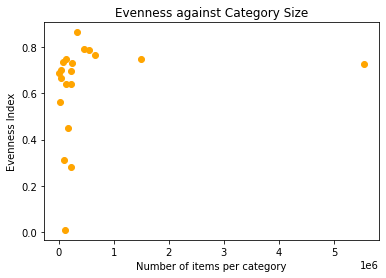

Correlation Coefficient: 0.1906


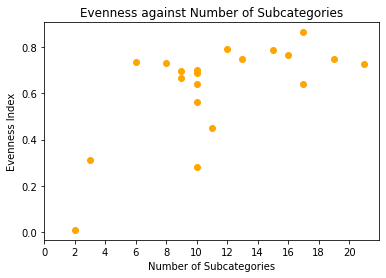

Correlation Coefficient 0.6283


In [15]:
cats = 'ABCDGHJKLMNPQRSTUVZ'
fig, ax = pyplot.subplots()
ax.scatter(sizes, evenness, c=['orange'])
pyplot.title("Evenness against Category Size")
pyplot.xlabel("Number of items per category")
pyplot.ylabel("Evenness Index")
pyplot.show()
r1 = correlation(evenness, sizes)
print('Correlation Coefficient:', round(r1, 4))

fig, ax = pyplot.subplots()
ax.scatter(numSubcats, evenness, c=['orange'])
pyplot.title("Evenness against Number of Subcategories")
pyplot.xlabel("Number of Subcategories")
pyplot.ylabel("Evenness Index")
pyplot.xticks(np.arange(0, 22, step=2))
pyplot.show()
r2 = correlation(evenness, numSubcats)
print('Correlation Coefficient', round(r2, 4))


In [16]:
def shanEntropy(counts):
    totalItems = sum(counts)
    P = [item/totalItems for item in counts]
    summation = 0 
    for i in range(len(P)):
        summation += P[i]*(math.log(P[i], 2))
    return -summation 

def normEntropy(counts):
    entropy = shanEntropy(counts)
    return entropy / math.log(len(counts), 2)

In [17]:
entropies = [normEntropy(generalCounts)]
print("Normalized Entropy\n")
print('Top','\t', round(normEntropy(generalCounts), 3))
for cat in 'ABCDGHJKLMNPQRSTUVZ':
    entropy = normEntropy(subCounts[cat])
    entropies.append(entropy)
    print(cat, '\t', round(entropy, 3))

Normalized Entropy

Top 	 0.831
A 	 0.701
B 	 0.881
C 	 0.821
D 	 0.825
G 	 0.803
H 	 0.873
J 	 0.857
K 	 0.429
L 	 0.555
M 	 0.548
N 	 0.878
P 	 0.81
Q 	 0.91
R 	 0.752
S 	 0.895
T 	 0.944
U 	 0.788
V 	 0.805
Z 	 0.05


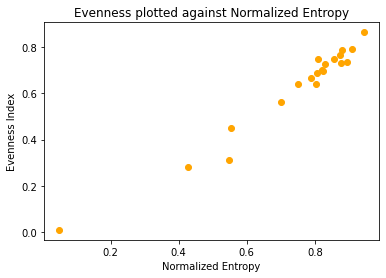

Correlation Coefficient: 0.9807


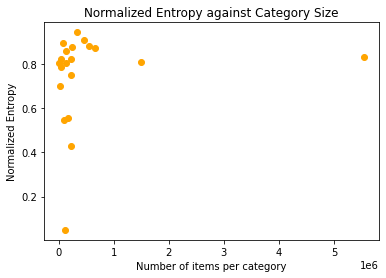

Correlation Coefficient: 0.1492


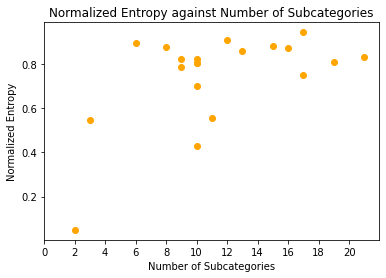

Correlation Coefficient 0.5394


In [18]:
fig, ax = pyplot.subplots()
ax.scatter(entropies, evenness,  c=['orange'])
pyplot.title("Evenness plotted against Normalized Entropy")
pyplot.xlabel("Normalized Entropy")
pyplot.ylabel("Evenness Index")
pyplot.show()
r1 = correlation(evenness, entropies)
print('Correlation Coefficient:', round(r1, 4))

fig, ax = pyplot.subplots()
ax.scatter(sizes, entropies, c=['orange'])
pyplot.title("Normalized Entropy against Category Size")
pyplot.xlabel("Number of items per category")
pyplot.ylabel("Normalized Entropy")
pyplot.show()
r1 = correlation(entropies, sizes)
print('Correlation Coefficient:', round(r1, 4))

fig, ax = pyplot.subplots()
ax.scatter(numSubcats, entropies, c=['orange'])
pyplot.title("Normalized Entropy against Number of Subcategories")
pyplot.xlabel("Number of Subcategories")
pyplot.ylabel("Normalized Entropy")
pyplot.xticks(np.arange(0, 22, step=2))
pyplot.show()
r2 = correlation(entropies, numSubcats)
print('Correlation Coefficient', round(r2, 4))


- Could look at Kl-divergence from optimal split (evenly divided) 
- Could try normalizing entropy 
- Could look at information gain for going into a given category 
- pure entropy alone is not very informative 

In [35]:
with open ('classStructures.pk', 'rb') as f:
    A = pickle.load(f)
    B = pickle.load(f)
    C = pickle.load(f)
    D = pickle.load(f)
    G = pickle.load(f)
    H = pickle.load(f)
    J = pickle.load(f)
    L = pickle.load(f)
    N = pickle.load(f)
    P = pickle.load(f)
    Q = pickle.load(f)
    R = pickle.load(f)
    S = pickle.load(f)
    T = pickle.load(f)
    U = pickle.load(f)
    V = pickle.load(f)
    Z = pickle.load(f)

In [36]:
class AlphaNode:
    def __init__(self, label, name):
        self.label = label 
        self.name = name
        self.children = []
        self.child_idx = []
        self.numBooks = 0

    def __str__(self, level=0):
        out = "\t"*level+repr(self.label)+"\n"
        for child in self.children:
            out += child.__str__(level+1)
        return out
    
    def add_child(self, label, name):
        child = AlphaNode(label, name)
        self.children.append(child)
        self.child_idx.append(label)
    
    def add_children(self, cat_list):
        for tup in cat_list:
            self.add_child(tup[0], tup[1])
    
    def print_children(self):
        for child in self.children:
            print(child.label)

    def add_num_child(self, cat_list):
        for tup in cat_list:
            self.children.append(NumNode(tup[0], tup[1]))

In [37]:
class NumNode:
    def __init__(self, min_val, max_val, parent=None):
        self.label = str(min_val) + "-" + str(max_val)
        self.min_val = min_val
        self.max_val = max_val 
        self.children = [] 
        self.child_idx = []
        self.parent = parent
        self.numBooks = 0

    def __str__(self, level=0):
        out = "\t"*level+repr(self.label)+"\n"
        for child in self.children:
            out += child.__str__(level+1)
        return out


def add_children(num_list):
    node_list = [NumNode(tup[0], tup[1]) for tup in num_list]
    node_list.reverse()
    if len(num_list) == 1:
        roots = node_list
    else:
        for i in range(len(node_list)-1):
            head = node_list[i]
            tail = node_list[i+1:]
            for node in tail:
                if head.min_val >= node.min_val and head.max_val <= node.max_val:
                    head.parent = node
                    node.children.insert(0, head)
                    node.child_idx.insert(0, head.min_val)
                    break
        node_list.reverse()
        roots = [node for node in node_list if node.parent is None]
    return roots



In [38]:
print(A)

'A'
	'C'
		'1.0-999.0'
			'1.0-195.0'
				'1.0-8.0'
				'9.0-195.0'
			'200.0-200.0'
			'801.0-895.0'
			'901.0-995.0'
			'999.0-999.0'
	'E'
		'1.0-90.0'
			'5.0-90.0'
	'G'
		'2.0-600.0'
	'I'
		'1.0-21.0'
	'M'
		'1.0-501.0'
			'10.0-100.0'
			'111.0-160.0'
			'200.0-501.0'
	'N'
	'P'
		'1.0-271.0'
			'101.0-115.0'
			'200.0-230.0'
			'250.0-265.0'
			'270.0-271.0'
	'S'
		'1.0-945.0'
			'2.5-4.0'
			'11.0-785.0'
	'Y'
		'10.0-2001.0'
			'10.0-29.0'
			'30.0-1730.0'
			'2001.0-2001.0'
	'Z'
		'20.0-999.0'
			'101.0-181.0'
			'191.0-193.0'
			'200.0-361.0'
			'501.0-908.0'



In [39]:
A_books = [lccn[1][0] for lccn in lccnDat if len(lccn[1][0]) > 0 and lccn[1][0][0] == 'A']
print(len(A_books))
print(A_books[:10])

31705
['AC8', 'AC35', 'AC8', 'AC8', 'AC8', 'AC8', 'AE5', 'AG5', 'AG5', 'AC5']


In [40]:
def hasLetters(string):
    return any(char.isalpha() for char in string)
    
def parseTree(node, num):
    while node.children != []:
        flag = False
        for child in node.children:
            if float(num) >= child.min_val and float(num) <= child.max_val:
                node = child 
                node.numBooks += 1
                flag = True 
        # if not in any of children
        if flag is False:
            break 
            
            
  
print(A.children[0].numBooks)

0


In [41]:
subCats = A.child_idx
for num in A_books:
    subClass = num[1]
    idx = num.find('.')
    if idx != -1:
        subStr = num[idx+1:]
        if hasLetters(subStr):
            number = num[2:idx]
        else:
            number = num[2:]
    else:
        number = num[2:]    
    
    if subClass in subCats:
        c_idx = subCats.index(subClass)
        A.children[c_idx].numBooks += 1
        tree = A.children[c_idx]
        try:
            parseTree(tree, number)
        except ValueError:
            pass

12858


In [42]:
print(A.children[0].numBooks, A.child_idx[0])

12858 C
